<a href="https://colab.research.google.com/github/tnwls6865/cau_deep_learning/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 및 자연어 처리를 위한 딥러닝 실습

## Transformer from Scratch

In [2]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
# import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

### 단어 임베딩 생성 (Word Embeddings)

1. 입력 시퀀스의 각 단어를 임베딩 벡터로 변환.
   - 임베딩 벡터는 각 단어를 더 의미론적으로 표현.

2. 임베딩 벡터 차원 및 단어 집합 크기 예시:
   - 임베딩 벡터 차원: 512
   - 단어 집합 크기(Vocab Size): 100
   - 임베딩 매트릭스 크기: **100 x 512**
     - 학습 과정에서 학습됨.
     - 추론 시 각 단어가 해당 512차원 벡터에 매핑.

3. 배치 크기 및 시퀀스 길이 예시:
   - 배치 크기: 32
   - 시퀀스 길이: 10 (단어 10개)
   - 출력 크기: **32 x 10 x 512**

In [3]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        임베딩 레이어 초기화.
        Args:
            vocab_size: 어휘 크기
            embed_dim: 임베딩 차원
        """
        super(Embedding, self).__init__()
        # 임베딩 레이어 정의
        self.embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        """
        순전파 연산.
        Args:
            x: 입력 벡터 (토큰 인덱스)
        Returns:
            out: 임베딩 벡터
        """
        # 입력 데이터를 임베딩
        out = self.embed(x)
        return out

### 위치 인코딩(Positional Encoding)

1. **위치 정보 필요성**
   - 모델이 문장을 이해하려면 각 단어에 대해 다음 두 가지 정보를 알아야 함:
     - 단어의 의미(semantic meaning).
     - 문장에서의 위치(position).

2. **위치 인코딩 방법**
   - "Attention is All You Need" 논문에서는 다음과 같은 함수 사용:
     - **홀수 위치**: 코사인(cosine) 함수 사용.
     - **짝수 위치**: 사인(sine) 함수 사용.
   - 주요 변수:
     - `pos`: 문장에서의 단어 순서.
     - `i`: 임베딩 벡터 차원에서의 위치.

3. **위치 인코딩 매트릭스**
   - 임베딩 매트릭스와 유사한 형태로 생성.
   - 매트릭스 크기: **시퀀스 길이 x 임베딩 차원**.

4. **단어와 위치 벡터 결합**
   - 각 토큰(단어)에 대해:
     - 단어 임베딩 벡터: 크기 **1 x 512**.
     - 위치 벡터: 크기 **1 x 512**.
     - 두 벡터를 합산하여 최종 출력 벡터 생성: **1 x 512**.

5. **예시**
   - 배치 크기: 32.
   - 시퀀스 길이: 10.
   - 임베딩 차원: 512.
   - **단어 임베딩 벡터**: 크기 **32 x 10 x 512**.
   - **위치 인코딩 벡터**: 크기 **32 x 10 x 512**.
   - 두 벡터를 더하여 최종 출력 생성: **32 x 10 x 512**.

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        """
        위치 임베딩 레이어 초기화.
        Args:
            max_seq_len: 입력 시퀀스의 최대 길이
            embed_model_dim: 임베딩 차원
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        # 위치 임베딩 초기화
        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                # 짝수 인덱스에 대해 sin 값을 계산
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                # 홀수 인덱스에 대해 cos 값을 계산
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embed_dim)))
        # 첫 번째 배치 차원을 추가
        pe = pe.unsqueeze(0)
        # 위치 임베딩을 고정된 텐서로 등록
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        순전파 연산.
        Args:
            x: 입력 벡터
        Returns:
            x: 위치 정보가 추가된 출력 벡터
        """
        # 임베딩을 상대적으로 더 크게 만듦
        x = x * math.sqrt(self.embed_dim)
        # 임베딩에 위치 정보를 추가
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:, :seq_len], requires_grad=False)
        return x

### Self-Attention 및 Multihead Attention 이해하기

#### **Self-Attention이란?**
1. **필요성**
   - 예: "Dog is crossing the street because it saw the kitchen" 문장에서 "it"이 무엇을 지칭하는지 인간은 쉽게 이해할 수 있지만, 머신은 이를 이해하기 어려움.
   - Self-Attention은 모델이 입력 시퀀스의 다른 위치를 참조하도록 하여 단어 간 의존성을 계산하는 역할을 함.

2. **작동 방식**
   - 각 단어를 처리할 때, Self-Attention은 다른 단어와의 관계를 기반으로 벡터를 생성.

---

#### **Self-Attention 단계별 설명**

**Step 1: Query, Key, Value 벡터 생성**
- 입력 벡터(각 단어의 임베딩)를 사용해 Query, Key, Value 벡터 생성.
- 벡터 크기: **1 x 64** (각 벡터).
- Multihead Attention에서는 Self-Attention을 병렬적으로 수행하며, 8개의 Attention Head 사용.

**Key, Query, Value 생성 방식**
- 학습 가능한 Key, Query, Value 행렬 사용.
- 학습 중 이 행렬들이 최적화되어 Query, Key, Value 벡터 생성.

---

**Step 2: Score 계산**
- Query 벡터와 Key 벡터를 내적(dot product): **[Q x Kᵀ]**.
- 각 단어 간의 유사도를 계산하는 과정.

---

**Step 3: 정규화 및 Softmax 적용**
- Score를 Key 벡터 차원의 제곱근으로 나눔.
- Softmax를 적용하여 가중치(normalized weights)를 생성.

---

**Step 4: Value 벡터와 곱하기**
- Softmax 결과를 Value 벡터와 곱하여 가중합(weighted sum) 계산.

---

**Step 5: 선형 레이어 통과**
- 최종 가중합 벡터를 선형 레이어에 전달하여 Multihead Attention 출력 생성.

---

### **Multihead Attention**
- 여러 Self-Attention Head(예: 8개)를 독립적으로 실행.
- 각 Head의 출력을 결합하여 더 풍부한 표현 생성.
- 이를 통해 다양한 관계와 패턴을 효과적으로 학습 가능.

---

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Multi-Head Self-Attention 클래스 초기화.
        Args:
            embed_dim: 임베딩 벡터 출력 차원
            n_heads: Self-Attention 헤드의 수
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim  # 전체 임베딩 차원 (예: 512)
        self.n_heads = n_heads  # 멀티 헤드의 수 (예: 8)
        self.single_head_dim = int(self.embed_dim / self.n_heads)  # 각 헤드의 차원 (예: 64)

        # Query, Key, Value를 생성하기 위한 선형 레이어 정의
        self.query_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.key_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)

        # 멀티 헤드의 결과를 결합한 출력 레이어
        self.out = nn.Linear(self.n_heads * self.single_head_dim, self.embed_dim)

    def forward(self, key, query, value, mask=None):
        """
        순전파 연산.
        Args:
            key: Key 벡터 (batch_size x seq_length x embedding_dim)
            query: Query 벡터 (batch_size x seq_length x embedding_dim)
            value: Value 벡터 (batch_size x seq_length x embedding_dim)
            mask: 디코더에서 사용되는 마스크 텐서 (선택적)

        Returns:
            Multi-Head Attention 출력 벡터
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        seq_length_query = query.size(1)  # Query 길이는 디코더 추론 시 변경될 수 있음

        # Key, Query, Value를 멀티 헤드로 나눔
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

        # Query, Key, Value에 선형 변환 적용
        k = self.key_matrix(key)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        # 차원을 변환하여 멀티 헤드 계산에 맞춤
        q = q.transpose(1, 2)  # (batch_size, n_heads, seq_length_query, single_head_dim)
        k = k.transpose(1, 2)  # (batch_size, n_heads, seq_length, single_head_dim)
        v = v.transpose(1, 2)  # (batch_size, n_heads, seq_length, single_head_dim)

        # Key를 행렬 곱에 맞게 변환
        k_adjusted = k.transpose(-1, -2)  # (batch_size, n_heads, single_head_dim, seq_length)

        # Query와 Key의 행렬 곱 수행
        product = torch.matmul(q, k_adjusted)  # (batch_size, n_heads, seq_length_query, seq_length)

        # 마스크가 주어지면, 마스크 위치를 큰 음수 값으로 채움
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        # Key 차원의 제곱근으로 나눔 (스케일링)
        product = product / math.sqrt(self.single_head_dim)

        # Softmax를 적용하여 Attention Score 계산
        scores = F.softmax(product, dim=-1)

        # Attention Score와 Value를 곱함
        scores = torch.matmul(scores, v)  # (batch_size, n_heads, seq_length_query, single_head_dim)

        # 멀티 헤드 결과를 결합
        concat = scores.transpose(1, 2).contiguous().view(batch_size, seq_length_query, self.single_head_dim * self.n_heads)

        # 출력 레이어를 통해 최종 출력 생성
        output = self.out(concat)

        return output

### **Encoder 구조**

#### **Step-by-Step 과정**

1. **입력 처리**
   - 문장에 해당하는 패딩된 토큰(padded tokens)을 **임베딩 레이어**와 **위치 인코딩 레이어**에 통과.
   - 결과: 각 단어가 임베딩된 벡터와 위치 정보가 더해진 형태로 변환.

---

2. **Multihead Attention**
   - 위에서 설명한 **Multihead Attention Layer**에 입력 전달.
   - 단어 간 의존성을 바탕으로 유용한 표현(Representational Matrix) 생성.

---

3. **정규화(Normalization)와 잔차 연결(Residual Connection)**
   - **Multihead Attention 출력**에 **입력값**을 더해 잔차 연결 수행.
   - 이 결과를 정규화(Normalization)하여 안정된 학습을 지원.

---

4. **Feed Forward Layer**
   - 정규화된 출력이 **Feed Forward Layer**로 전달.
   - 다시 **정규화**와 **잔차 연결** 수행:
     - 입력(Feed Forward Layer 입력값)과 정규화된 출력을 더함.
   - 최종적으로 **Encoder의 출력** 생성.

---

### **Encoder의 핵심**
- **Residual Connections**: 입력을 더해 안정성과 정보 보존 강화.
- **Normalization**: 학습 안정성 향상.
- **단계별 조합**:
  - 임베딩 + 위치 인코딩 → Multihead Attention → 정규화 + 잔차 → Feed Forward Layer → 정규화 + 잔차.

이 과정을 통해 문장의 의미와 구조를 잘 표현한 **Encoder 출력**을 생성.

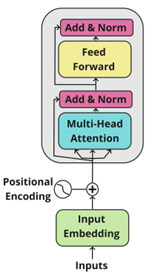

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        """
        Transformer 블록 초기화.
        Args:
           embed_dim: 임베딩 차원
           expansion_factor: 피드 포워드 레이어 출력 차원의 확장 비율
           n_heads: Multi-Head Attention 헤드의 수
        """
        super(TransformerBlock, self).__init__()

        # Multi-Head Attention 레이어
        self.attention = MultiHeadAttention(embed_dim, n_heads)

        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # 피드 포워드 네트워크
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, expansion_factor * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion_factor * embed_dim, embed_dim)
        )

        # 드롭아웃
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, key, query, value):
        """
        Transformer 블록의 순전파 연산.
        Args:
           key: Key 벡터
           query: Query 벡터
           value: Value 벡터
        Returns:
           norm2_out: Transformer 블록의 출력
        """
        # Multi-Head Attention 출력 및 Residual Connection
        attention_out = self.attention(key, query, value)
        attention_residual_out = attention_out + value
        norm1_out = self.dropout1(self.norm1(attention_residual_out))

        # 피드 포워드 네트워크 출력 및 Residual Connection
        feed_fwd_out = self.feed_forward(norm1_out)
        feed_fwd_residual_out = feed_fwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))

        return norm2_out


class TransformerEncoder(nn.Module):
    """
    Transformer 인코더 클래스.
    Args:
        seq_len: 입력 시퀀스 길이
        vocab_size: 어휘 크기
        embed_dim: 임베딩 차원
        num_layers: 인코더 레이어 수
        expansion_factor: 피드 포워드 레이어 확장 비율
        n_heads: Multi-Head Attention 헤드의 수
    Returns:
        out: 인코더 출력
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()

        # 임베딩 레이어
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        # 위치 임베딩 레이어
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        # Transformer 블록 레이어 리스트
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, expansion_factor, n_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        """
        Transformer 인코더의 순전파 연산.
        Args:
            x: 입력 시퀀스
        Returns:
            out: 인코더 출력
        """
        # 입력 시퀀스를 임베딩
        embed_out = self.embedding_layer(x)
        # 위치 임베딩 추가
        out = self.positional_encoder(embed_out)
        # Transformer 블록을 순차적으로 통과
        for layer in self.layers:
            out = layer(out, out, out)

        return out

### **Decoder 구조**

#### **Step-by-Step 과정**

---

#### **Step 1: 임베딩 및 위치 인코딩**
- 타겟 시퀀스의 각 단어를 임베딩 레이어와 위치 인코딩 레이어에 통과.
- 결과: 각 단어에 대해 **1 x 512** 차원의 임베딩 벡터 생성.

---

#### **Step 2: 첫 번째 Multihead Attention**
- 임베딩 출력이 **Multihead Attention Layer**로 전달.
- Query, Key, Value 행렬은 타겟 입력에서 생성.
- **Mask** 사용:
  - 이유: 타겟 단어의 Attention 계산 시, **미래 단어**를 참조하지 않도록 막음.
  - 예: "I am a student"에서 "a"는 "student"를 참조하지 않음.

---

#### **Step 3: Add & Norm**
- 첫 번째 Multihead Attention 출력과 임베딩 출력을 합산(Add).
- 이 합산 결과를 정규화(Normalization).

---

#### **Step 4: Encoder-Decoder Multihead Attention**
- **Encoder-Decoder Attention**을 위해 Multihead Attention Layer 사용:
  - **Key**와 **Value** 벡터: **Encoder 출력**에서 생성.
  - **Query** 벡터: 이전 Decoder 레이어 출력(첫 번째 Add & Norm 결과)에서 생성.
- Encoder-Decoder Multihead Attention 결과를 **Add & Norm Layer**에 전달:
  - 이전 Add & Norm 출력과 Encoder-Decoder Attention 출력을 합산(Add).
  - 정규화(Normalization) 수행.

---

#### **Step 5: Feed Forward Layer**
- 출력이 Feed Forward Layer(선형 레이어)에 전달.
- **Add & Norm Layer** 적용:
  - Feed Forward Layer 출력과 입력(Add & Norm의 입력)을 합산.
  - 정규화(Normalization).

---

#### **Step 6: 최종 출력**
- 최종 출력이 선형 레이어로 전달:
  - 레이어 출력 크기: 타겟 코퍼스의 단어 수(어휘 크기).
- **Softmax 함수** 적용:
  - 각 단어의 확률 분포 생성.
  - 다음 단어의 확률 예측.

---

### **Decoder의 핵심**
1. **두 종류의 Multihead Attention**
   - **타겟 Attention**: 미래 단어를 참조하지 않도록 **Mask** 사용.
   - **Encoder-Decoder Attention**: Encoder 출력(Key, Value)과 Decoder 입력(Query) 간 관계 학습.
2. **Residual Connection과 Normalization**
   - 각 주요 단계에서 안정성 및 정보 보존 강화.
3. **Softmax를 통한 단어 확률 계산**
   - 타겟 단어의 확률적 분포 생성으로 다음 단어 예측 가능.

---

Decoder는 Encoder의 출력을 활용하여 문맥과 타겟 시퀀스의 관계를 학습하며, 최종적으로 단어 예측을 위한 확률 분포를 생성합니다.

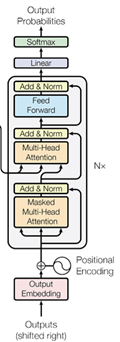

In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        """
        Transformer 디코더 블록 초기화.
        Args:
           embed_dim: 임베딩 차원
           expansion_factor: 피드 포워드 레이어 출력 차원의 확장 비율
           n_heads: Multi-Head Attention 헤드의 수
        """
        super(DecoderBlock, self).__init__()

        # Multi-Head Attention
        self.attention = MultiHeadAttention(embed_dim, n_heads=n_heads)
        # Layer Normalization
        self.norm = nn.LayerNorm(embed_dim)
        # 드롭아웃
        self.dropout = nn.Dropout(0.2)
        # Transformer 블록
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)

    def forward(self, key, query, x, mask):
        """
        Transformer 디코더 블록의 순전파 연산.
        Args:
           key: Key 벡터
           query: Query 벡터
           x: Value 벡터
           mask: Self-Attention에서 사용되는 마스크
        Returns:
           out: Transformer 블록의 출력
        """
        # Self-Attention 계산 (마스크 적용)
        attention = self.attention(x, x, x, mask=mask)  # (batch_size, seq_len, embed_dim)
        # Residual Connection과 Normalization 적용
        value = self.dropout(self.norm(attention + x))
        # Transformer 블록으로 출력 처리
        out = self.transformer_block(key, query, value)
        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        """
        Transformer 디코더 초기화.
        Args:
           target_vocab_size: 타겟 어휘 크기
           embed_dim: 임베딩 차원
           seq_len: 입력 시퀀스 길이
           num_layers: 디코더 레이어 수
           expansion_factor: 피드 포워드 레이어 확장 비율
           n_heads: Multi-Head Attention 헤드의 수
        """
        super(TransformerDecoder, self).__init__()

        # 단어 임베딩 레이어
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        # 위치 임베딩 레이어
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)
        # 디코더 블록 리스트
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=expansion_factor, n_heads=n_heads)
                for _ in range(num_layers)
            ]
        )
        # 출력 레이어 (어휘 크기로 매핑)
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        # 드롭아웃
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):
        """
        Transformer 디코더의 순전파 연산.
        Args:
            x: 타겟 입력 벡터
            enc_out: 인코더 출력
            mask: 디코더 Self-Attention에서 사용되는 마스크
        Returns:
            out: 디코더 출력 벡터
        """
        # 단어 임베딩과 위치 임베딩 적용
        x = self.word_embedding(x)  # (batch_size, seq_len, embed_dim)
        x = self.position_embedding(x)  # (batch_size, seq_len, embed_dim)
        x = self.dropout(x)

        # 모든 디코더 블록 통과
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        # 출력 레이어로 어휘 점수 계산
        out = F.softmax(self.fc_out(x), dim=-1)

        return out

In [8]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length, num_layers=2, expansion_factor=4, n_heads=8):
        """
        Transformer 모델 초기화.
        Args:
           embed_dim: 임베딩 차원
           src_vocab_size: 소스 어휘 크기
           target_vocab_size: 타겟 어휘 크기
           seq_length: 입력 시퀀스 길이
           num_layers: 인코더와 디코더 레이어 수
           expansion_factor: 피드 포워드 레이어 확장 비율
           n_heads: Multi-Head Attention 헤드의 수
        """
        super(Transformer, self).__init__()
        self.target_vocab_size = target_vocab_size

        # Transformer 인코더
        self.encoder = TransformerEncoder(
            seq_length, src_vocab_size, embed_dim,
            num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads
        )
        # Transformer 디코더
        self.decoder = TransformerDecoder(
            target_vocab_size, embed_dim, seq_length,
            num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads
        )

    def make_trg_mask(self, trg):
        """
        타겟 마스크 생성.
        Args:
            trg: 타겟 시퀀스
        Returns:
            trg_mask: 타겟 마스크 (하삼각 행렬)
        """
        batch_size, trg_len = trg.shape
        # 하삼각 행렬 생성
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def decode(self, src, trg):
        """
        추론 모드에서 디코딩 수행.
        Args:
            src: 인코더 입력
            trg: 디코더 입력
        Returns:
            out_labels: 최종 예측된 시퀀스
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size, seq_len = src.shape[0], src.shape[1]
        out = trg

        for i in range(seq_len):
            # 디코더를 통해 예측
            out = self.decoder(out, enc_out, trg_mask)  # (batch_size, seq_len, vocab_size)
            # 마지막 토큰 추출
            out = out[:, -1, :]
            # 가장 높은 확률의 단어를 선택
            out = out.argmax(-1)
            out_labels.append(out.item())
            # 예측된 토큰을 디코더 입력으로 추가
            out = torch.unsqueeze(out, axis=0)

        return out_labels

    def forward(self, src, trg):
        """
        순전파 연산.
        Args:
            src: 인코더 입력
            trg: 디코더 입력
        Returns:
            outputs: 타겟 단어의 확률 분포
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

### 코드 테스트

In [9]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1],
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1],
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)

In [10]:
model

Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [11]:
out = model(src, target)
out.shape

torch.Size([2, 12, 11])

### Inference

In [12]:
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)



src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])
trg = torch.tensor([[0]])
print(src.shape,trg.shape)
out = model.decode(src, trg)

torch.Size([1, 12]) torch.Size([1, 1])


In [13]:
out

[6, 0, 8, 4, 0, 8, 7, 0, 7, 7, 0, 7]

## nn.Transformer 활용

In [3]:
!pip install torchtext==0.6.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.8 MB/s eta 0:00:00


In [4]:
import math

import torch
import torch.nn as nn

import torchtext

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.datasets import IMDB
from torchtext.vocab import GloVe

# 배치 크기와 최대 시퀀스 길이 설정
batch_size = 30
max_length = 256

# TEXT와 LABEL 필드 정의
# TEXT: 텍스트 데이터 처리, 소문자로 변환, 길이 포함 제외, 배치 우선
TEXT = Field(lower=True, include_lengths=False, batch_first=True)

# LABEL: 라벨 데이터 처리, 순서가 필요하지 않음
LABEL = Field(sequential=False)

# IMDB 데이터셋 로드 및 분할
train_txt, test_txt = IMDB.splits(TEXT, LABEL)

# 단어 사전 생성 및 GloVe 벡터 로드
TEXT.build_vocab(
    train_txt,  # 학습 데이터 기반으로 단어 사전 생성
    vectors=GloVe(name="6B", dim=50, max_vectors=50_000),  # 사전 학습된 GloVe 임베딩 로드
    max_size=50_000,  # 최대 단어 개수
)

# 라벨 사전 생성
LABEL.build_vocab(train_txt)

# 데이터셋을 BucketIterator로 변환
# 데이터를 배치 크기 단위로 그룹화하고, 길이에 따라 정렬하여 효율적으로 처리
train_iter, test_iter = BucketIterator.splits(
    (train_txt, test_txt),
    batch_size=batch_size,
)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:28<00:00, 2.97MB/s]
.vector_cache/glove.6B.zip: 862MB [02:41, 5.33MB/s]                           
100%|█████████▉| 49999/50000 [00:01<00:00, 32956.46it/s]


In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

사전 학습된 임베딩: nn.Embedding.from_pretrained를 통해 사전 학습된 임베딩을 불러오며, 학습 가능하게 설정.

위치 인코딩: PositionalEncoding 클래스를 통해 위치 정보를 추가.

Transformer 인코더: nn.TransformerEncoderLayer를 기반으로 다중 레이어 Transformer 인코더를 구성.

분류기: Transformer 인코더 출력의 평균을 계산하여 문장 수준 표현 생성. 마지막으로 nn.Linear를 통해 이진 분류 수행.

출력: 최종 출력은 타겟 클래스에 대한 로짓.

In [7]:
class Net(nn.Module):
    """
    텍스트 분류기: PyTorch TransformerEncoder를 기반으로 구현.
    """

    def __init__(
        self,
        embeddings,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):
        """
        Args:
            embeddings: 사전 학습된 임베딩 텐서
            nhead: Multi-Head Attention 헤드의 수
            dim_feedforward: 피드 포워드 레이어의 차원
            num_layers: Transformer 인코더 레이어의 수
            dropout: 드롭아웃 비율
            activation: 활성화 함수 (기본값: "relu")
            classifier_dropout: 분류기 레이어의 드롭아웃 비율
        """
        super().__init__()

        vocab_size, d_model = embeddings.size()
        assert d_model % nhead == 0, "nhead는 d_model로 나누어떨어져야 합니다."

        # 임베딩 레이어 (사전 학습된 임베딩 사용, 학습 가능 설정)
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        # 위치 인코딩 레이어
        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        # TransformerEncoderLayer 정의
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

        # Transformer 인코더 구성
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # 분류기 레이어
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        """
        순전파 연산.
        Args:
            x: 입력 텐서 (시퀀스)
        Returns:
            x: 분류 결과 (로지츠)
        """
        # 입력 임베딩 및 스케일링
        x = self.emb(x) * math.sqrt(self.d_model)
        # 위치 인코딩 추가
        x = self.pos_encoder(x)
        # Transformer 인코더 적용
        x = self.transformer_encoder(x)
        # 시퀀스 차원에 대해 평균 (문장 수준 표현)
        x = x.mean(dim=1)
        # 분류기 통과
        x = self.classifier(x)

        return x

In [9]:
epochs = 5

# 모델 초기화
model = Net(
    TEXT.vocab.vectors,
    nhead=5,  # Multi-Head Attention 모델에서의 헤드 수
    dim_feedforward=50,  # nn.TransformerEncoder에서 피드 포워드 네트워크의 차원
    num_layers=6,
    dropout=0.0,
    classifier_dropout=0.0,
).to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
lr = 1e-4
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr
)

# 랜덤 시드 설정
torch.manual_seed(0)

print("Starting training...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # 학습 손실 및 정확도 초기화
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0

    # 모델을 학습 모드로 설정
    model.train()
    for idx, batch in enumerate(iter(train_iter)):
        # 예측 값 계산
        predictions = model(batch.text.to(device))
        labels = batch.label.to(device) - 1

        # 손실 계산
        loss = criterion(predictions, labels)

        # 정확도 계산
        correct = predictions.argmax(axis=1) == labels
        epoch_correct += correct.sum().item()
        epoch_count += correct.size(0)

        # 손실 합산
        epoch_loss += loss.item()

        # 역전파 및 가중치 업데이트
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        optimizer.zero_grad()

    # 검증 손실 및 정확도 초기화
    test_epoch_loss = 0
    test_epoch_correct = 0
    test_epoch_count = 0

    # 모델을 평가 모드로 설정
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(iter(test_iter)):
            # 예측 값 계산
            predictions = model(batch.text.to(device))
            labels = batch.label.to(device) - 1

            # 검증 손실 계산
            test_loss = criterion(predictions, labels)

            # 정확도 계산
            correct = predictions.argmax(axis=1) == labels
            test_epoch_correct += correct.sum().item()
            test_epoch_count += correct.size(0)

            # 검증 손실 합산
            test_epoch_loss += test_loss.item()

    # Epoch 결과 출력
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {epoch_correct / epoch_count:.4f}")
    print(f"Validation Loss: {test_epoch_loss:.4f}")
    print(f"Validation Accuracy: {test_epoch_correct / test_epoch_count:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting training...
Epoch 1/5
Training Loss: 572.0046
Training Accuracy: 0.5389
Validation Loss: 583.0859
Validation Accuracy: 0.5930
Epoch 2/5
Training Loss: 534.8585
Training Accuracy: 0.6479
Validation Loss: 538.5094
Validation Accuracy: 0.6594
Epoch 3/5
Training Loss: 514.0932
Training Accuracy: 0.6750
Validation Loss: 532.0345
Validation Accuracy: 0.6723
Epoch 4/5
Training Loss: 496.0080
Training Accuracy: 0.6966
Validation Loss: 560.0861
Validation Accuracy: 0.6642
Epoch 5/5
Training Loss: 481.6707
Training Accuracy: 0.7126
Validation Loss: 568.1376
Validation Accuracy: 0.6774


## 실 사용 코드 예시

실습 조교가 논문 작성 당시 실제로 사용했던 코드의 일부분입니다.

In [11]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [12]:
import os
import numpy as np
from datasets import load_dataset

def data_split_index(data_len: int, split_ratio: float = 0.1):

    split_num = int(data_len * split_ratio)

    split_index = np.random.choice(data_len, split_num, replace=False)
    origin_index = list(set(range(data_len)) - set(split_index))

    return origin_index, split_index

total_src_list, total_trg_list = dict(), dict()

dataset = load_dataset("imdb")

origin_index, split_index = data_split_index(data_len=len(dataset['test']['text']), split_ratio=0.5)

# 1) Train data load
total_src_list['train'] = np.array(dataset['train']['text'])
total_trg_list['train'] = np.array(dataset['train']['label'])

# 2) Valid data load
total_src_list['valid'] = np.array(dataset['test']['text'])[origin_index]
total_trg_list['valid'] = np.array(dataset['test']['label'])[origin_index]

# 3) Test data load
total_src_list['test'] = np.array(dataset['test']['text'])[split_index]
total_trg_list['test'] = np.array(dataset['test']['label'])[split_index]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [15]:
import torch
from torch.utils.data.dataset import Dataset

class Seq2LabelDataset(Dataset):
    def __init__(self, src_tokenizer, src_list: list = list(), trg_list: list = None,
                 min_len: int = 10, src_max_len: int = 300):

        self.src_tensor_list = list()
        self.trg_tensor_list = list()

        self.src_tokenizer = src_tokenizer

        self.min_len = min_len
        self.src_max_len = src_max_len

        assert len(src_list) == len(trg_list)
        for src, trg in zip(src_list, trg_list):
            self.src_tensor_list.append(src)
            self.trg_tensor_list.append(trg)

        self.num_data = len(self.src_tensor_list)

    def __getitem__(self, index):
        if len(self.src_tensor_list[index]) == 2:
            src_encoded_dict = \
                self.src_tokenizer(
                    self.src_tensor_list[index][0], self.src_tensor_list[index][1],
                    max_length=self.src_max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
        else:
            src_encoded_dict = \
                self.src_tokenizer(
                    self.src_tensor_list[index],
                    max_length=self.src_max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
        # src_input_ids = src_encoded_dict['input_ids'].squeeze(0)
        # src_attention_mask = src_encoded_dict['attention_mask'].squeeze(0)

        trg_label = self.trg_tensor_list[index]

        return (src_encoded_dict, trg_label)

    def __len__(self):
        return self.num_data

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader

model_name = 'google-bert/bert-base-uncased'

batch_size = 32
num_workers = 4

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(total_trg_list['train'])))
model.to(device)

dataset_dict = {
    'train': Seq2LabelDataset(src_tokenizer=tokenizer, src_list=total_src_list['train'], trg_list=total_trg_list['train'],
                            src_max_len=150),
    'valid': Seq2LabelDataset(src_tokenizer=tokenizer, src_list=total_src_list['valid'], trg_list=total_trg_list['valid'],
                            src_max_len=150)
}
dataloader_dict = {
    'train': DataLoader(dataset_dict['train'], drop_last=True, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=num_workers),
    'valid': DataLoader(dataset_dict['valid'], drop_last=True, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=num_workers)
}

print(f"Total number of trainingsets iterations - {len(dataset_dict['train'])}, {len(dataloader_dict['train'])}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of trainingsets iterations - 25000, 781


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
for i, batch_iter in enumerate(dataloader_dict['train']):

    # Input setting
    src_sequence = batch_iter[0]['input_ids'].to(device, non_blocking=True).squeeze(1)
    src_att = batch_iter[0]['attention_mask'].to(device, non_blocking=True).squeeze(1)
    trg_label = batch_iter[1].to(device, non_blocking=True)

    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
src_sequence

tensor([[  101,  1996, 12536,  ...,  2127,  2085,   102],
        [  101, 12831,  5506,  ...,  2175,  3308,   102],
        [  101,  1996,  3482,  ..., 11873,  1006,   102],
        ...,
        [  101,  1037,  2567,  ...,  3928,  2155,   102],
        [  101,  2004,  1045,  ...,     0,     0,     0],
        [  101,  1045,  2069,  ...,  2105,  1010,   102]], device='cuda:0')

In [22]:
trg_label

tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')